In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from network.pspnet import PSPNet
%matplotlib inline
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

In [20]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [21]:
from dataset import VOCDataset
from make_datapath_list import make_datapath_list
from data_transform import DataTransform

# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath
)

print(train_img_list[0])
print(train_anno_list[0])

# 動作確認
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.2043,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.2043,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.2043,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3256,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3256,  1.3431],
         [-0.7402, -0.4951, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


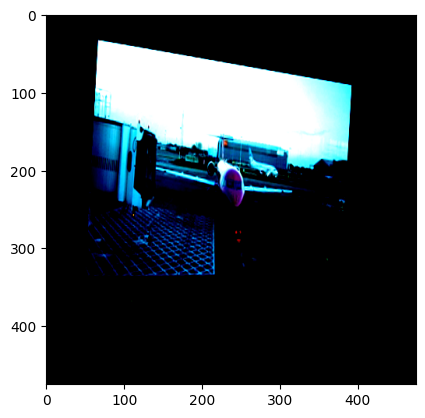

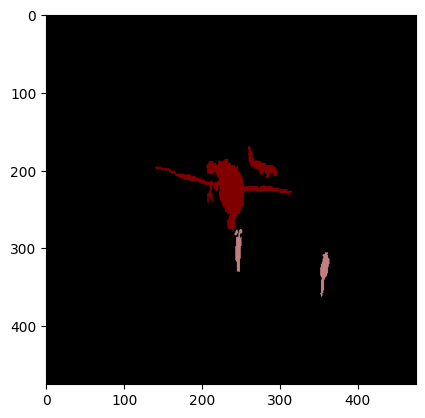

In [22]:
# 実行するたびに変わります

# 画像データの読み込み
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


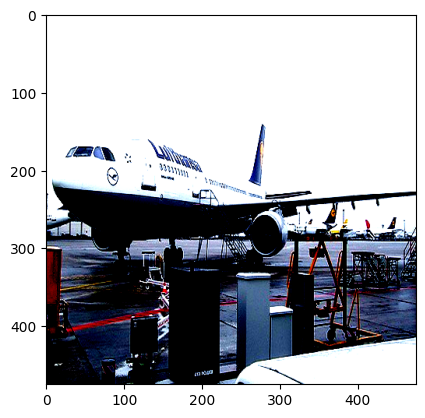

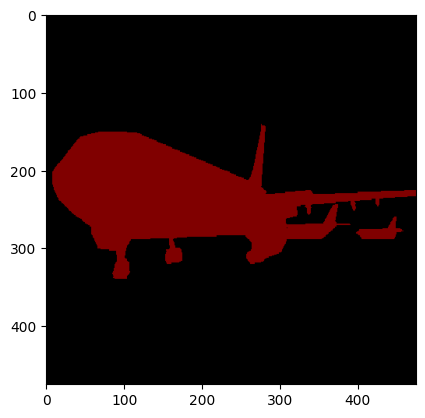

In [23]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

In [24]:
# モデルの定義
net = PSPNet(n_classes=21)
net
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)
out = net(dummy_img)
out

(tensor([[[[9.0631e-01, 2.8033e+00, 4.2588e-01,  ..., 1.0143e+00,
            3.1648e+00, 5.5183e-01],
           [0.0000e+00, 1.3769e+00, 5.2752e-01,  ..., 1.3283e-01,
            3.5257e+00, 1.3396e+00],
           [1.2106e+00, 2.2038e+00, 7.0561e-01,  ..., 2.4073e+00,
            0.0000e+00, 1.9426e+00],
           ...,
           [8.8424e-01, 0.0000e+00, 5.6837e-01,  ..., 1.7770e+00,
            0.0000e+00, 1.6299e+00],
           [1.1015e+00, 1.0756e+00, 1.7731e+00,  ..., 6.1686e-01,
            0.0000e+00, 0.0000e+00],
           [1.5843e+00, 1.0831e+00, 2.8329e+00,  ..., 0.0000e+00,
            0.0000e+00, 1.1333e+00]],
 
          [[1.2258e+00, 9.3147e-01, 3.9536e-02,  ..., 0.0000e+00,
            1.4570e+00, 5.8703e-01],
           [0.0000e+00, 1.0003e-01, 1.5064e+00,  ..., 0.0000e+00,
            0.0000e+00, 1.1558e+00],
           [0.0000e+00, 1.3652e-01, 0.0000e+00,  ..., 2.9005e-01,
            4.4718e-01, 1.6569e+00],
           ...,
           [1.2910e+00, 2.3993e+00, 2.

In [25]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset

# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [26]:
from network.pspnet import PSPNet

# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 付け替えた畳み込み層を初期化する。活性化関数がシグモイド関数なのでXavierを使用する。


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [27]:
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [28]:
from network.psploss import PSPLoss
criterion = PSPLoss(aux_weight=0.4)

In [31]:
import torch.optim as optim
from network.lr_scheduler import lambda_epoch
from train import train_model

optimizer = optim.SGD([
    {
        "params": net.feature_conv.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_res_1.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_res_2.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_dilated_res_1.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_dilated_res_2.parameters(), "lr": 1e-3
    },
    {
        "params": net.pyramid_pooling.parameters(), "lr": 1e-3
    },
    {
        "params": net.decode_feature.parameters(), "lr": 1e-2
    },
    {
        "params": net.aux.parameters(), "lr": 1e-2
    },
], momentum=0.9, weight_decay=0.0001)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
num_epochs = 30
train_model(
    net,
    dataloaders_dict,
    criterion,
    scheduler,
    optimizer,
    num_epochs
)

使用デバイス： cuda:0
-------------
Epoch 1/30
-------------
（train）


/home/fummicc1/codes/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA RTX A5000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A5000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
/home/fummicc1/codes/venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  war